In [1]:
import os
import json
import glob
import random
import collections

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from PIL import Image


TYPES = ["FLAIR", "T1w", "T2w", "T1wCE"]
WHITE_THRESHOLD = 10 # out of 255
EXCLUDE = [109, 123, 709]
train_df = pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")
test_df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [2]:
train_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


<AxesSubplot:xlabel='MGMT_value', ylabel='count'>

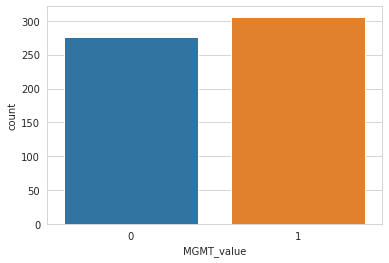

In [3]:
import seaborn as sns

sns.set_style('whitegrid')
sns.countplot(x='MGMT_value', data=train_df)

In [4]:
img_size = 224
scale = .8

In [5]:
def load_dicom(path, size = 224, scale = .8):
    ''' 
    Reads a DICOM image, standardizes so that the pixel values are between 0 and 1, then rescales to 0 and 255
    
    Note super sure if this kind of scaling is appropriate, but everyone seems to do it. 
    '''
#     dicom = pydicom.read_file(path)
#     data = dicom.pixel_array
#     if np.max(data) != 0:
#         data = data / np.max(data)
#     data = (data * 255).astype(np.uint8)
#     return cv2.resize(data, (size, size))
#     Load single image
    img = pydicom.read_file(path).pixel_array
    # Crop image
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    # Resize image
    img = cv2.resize(img, (size, size))
    return img

def get_all_image_paths(brats21id, image_type, folder='train'): 
    '''
    Returns an arry of all the images of a particular type for a particular patient ID
    '''
    assert(image_type in TYPES)
    
    patient_path = os.path.join(
        "../input/rsna-miccai-brain-tumor-radiogenomic-classification/%s/" % folder, 
        str(brats21id).zfill(5),
    )

    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*")), 
        key=lambda x: int(x[:-4].split("-")[-1]),
    )
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 3
    
    if num_images < 10: 
        interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder='train', size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(brats21id, image_type, folder)]
IMAGE_SIZE = 224

def get_all_data_for_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'train', IMAGE_SIZE)
        label = x['MGMT_value']

        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_for_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        x = test_df.loc[i]
        images = get_all_images(int(x['BraTS21ID']), image_type, 'test', IMAGE_SIZE)
        X += images
        test_ids += [int(x['BraTS21ID'])] * len(images)

    return np.array(X), np.array(test_ids)

# Image Scaling

In [6]:
data_directory = "../input/rsna-miccai-brain-tumor-radiogenomic-classification/"

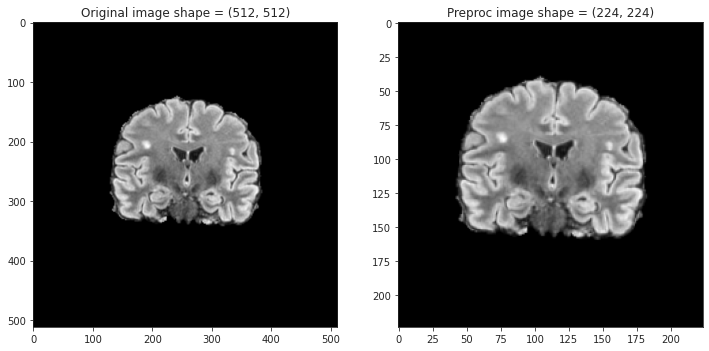

In [7]:
sns.set_style('ticks')
sample_img = pydicom.read_file(
    data_directory+"train/00046/FLAIR/Image-90.dcm").pixel_array
preproc_img = load_dicom(data_directory+"train/00046/FLAIR/Image-90.dcm")


fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(sample_img, cmap="gray")
ax1.set_title(f"Original image shape = {sample_img.shape}")
ax2 = plt.subplot(1,2,2)
ax2.imshow(preproc_img, cmap="gray")
ax2.set_title(f"Preproc image shape = {preproc_img.shape}")
plt.show()
fig.savefig("pre-proc.png")

# training

In [8]:
X, y, trainidt = get_all_data_for_train("FLAIR")

  0%|          | 0/582 [00:00<?, ?it/s]

In [9]:
X.shape, y.shape

((12458, 224, 224), (12458,))

In [10]:
label_count = np.bincount(y)
print("Total No. of Dataset", len(y))
print("No. of Malignant images", label_count[1])
print("No. of benevolent images", label_count[0])

Total No. of Dataset 12458
No. of Malignant images 7292
No. of benevolent images 5166


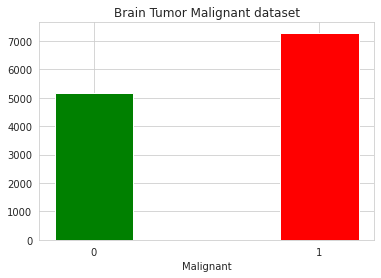

In [11]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
ind = [0,1]
c = ['green', 'red']
ax.bar(ind, [label_count[0], label_count[1]], 0.35, color=c)
ax.set_xticks(ind, labels=['0', '1'])
ax.set_title('Brain Tumor Malignant dataset')
ax.set_xlabel('Malignant')


plt.show()

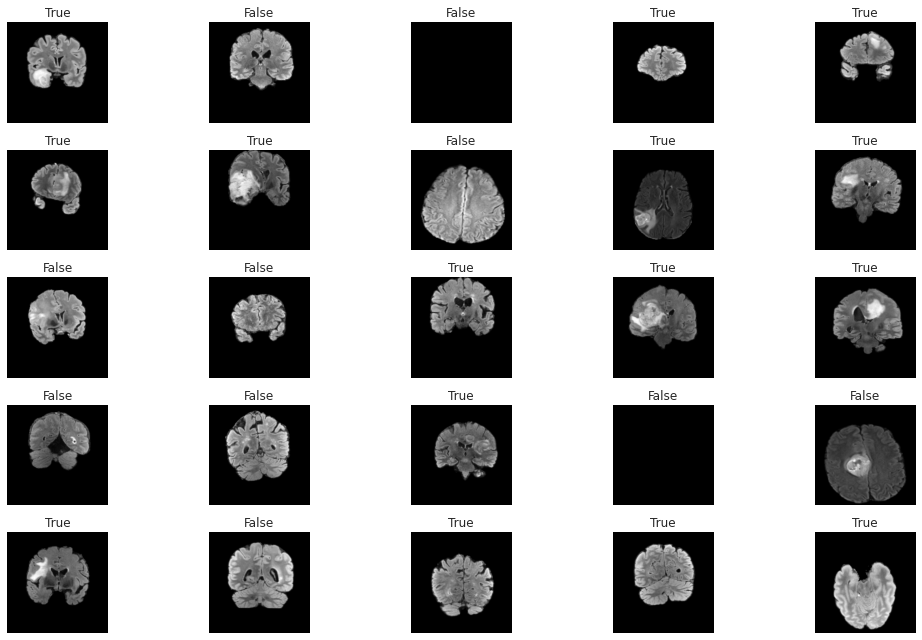

In [12]:
sns.set_style('ticks')
def visualize(imgs, targets):
    fig, ax = plt.subplots(5, 5, figsize=(15, 9))
    for i in range(5):
        for j in range(5):
            n = np.random.randint(0, len(X))
            img = X[n]
            label = y[n] == 1
            ax[i,j].imshow(img, cmap="gray")
            ax[i,j].axis('off')
            ax[i,j].set_title(label)
    plt.tight_layout()

visualize(X, y)

In [13]:
X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = train_test_split(X, y, trainidt, test_size=0.2, random_state=40)

X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, trainidt_train.shape, trainidt_valid.shape

2022-02-22 03:30:53.471856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 03:30:53.596841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 03:30:53.597624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 03:30:53.601374: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(TensorShape([9966, 224, 224, 1]),
 (9966, 2),
 TensorShape([2492, 224, 224, 1]),
 (2492, 2),
 (9966,),
 (2492,))

In [14]:
np.random.seed(0)
random.seed(12)
tf.random.set_seed(12)

inpt = keras.Input(shape=(224, 224, 1))

h = keras.layers.experimental.preprocessing.Rescaling(1./255)(inpt)
# h = data_augmentation(h)

# convolutional layer!
h = keras.layers.Conv2D(32, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_1", padding="valid")(h) 
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Conv2D(64, kernel_size=(3, 3),strides=(1,1), activation="relu", name="Conv_2", padding="same")(h) 
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
# pooling layer
h = keras.layers.MaxPool2D(pool_size=(2,2))(h) 
# h = tf.keras.layers.BatchNormalization(axis=-1)(h)
# convolutional layer!
h = keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name="Conv_3",padding ="same")(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
# pooling layer
# h = keras.layers.MaxPool2D(pool_size=(1,1))(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", name="Conv_4",padding ="valid")(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu", name="Conv_5",padding ="same")(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.MaxPool2D(pool_size=(2,2))(h)
h = tf.keras.layers.BatchNormalization(axis=-1)(h)
h = keras.layers.Dropout(0.3)(h)   

h = keras.layers.Flatten()(h) 
# h = global_average_layer(h)
h = keras.layers.Dense(128, activation='relu')(h)   

output = keras.layers.Dense(2, activation="softmax")(h)

model = keras.Model(inpt, output)

from tensorflow.keras.optimizers import SGD
# opt = SGD(lr=0.1)

checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_auc',
mode='max',
save_best_only=True,
save_freq='epoch')

model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.SGD(learning_rate =0.0001),
             metrics=[tf.keras.metrics.AUC(), "accuracy"])

In [15]:
len(model.layers)

20

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 1)       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 222, 222, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 222, 222, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0     

In [17]:
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
filepath=checkpoint_filepath,
save_weights_only=False,
monitor='val_accuracy',
mode='max',
save_best_only=True,
save_freq='epoch')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 3, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [early, learning_rate_reduction, model_checkpoint_callback]

In [40]:
history = model.fit(x=X_train, y = y_train, epochs=50, callbacks=callbacks_list, validation_data= (X_valid, y_valid))

Epoch 1/50
312/312 [==============================] - 44s 141ms/step - loss: 0.727018893 - auc: 0.619623005 - accuracy: 0.587763309 - val_loss: 0.689697683 - val_auc: 0.612146914 - val_accuracy: 0.586843133
Epoch 2/50
312/312 [==============================] - 44s 141ms/step - loss: 0.597844243 - auc: 0.740143895 - accuracy: 0.664493501 - val_loss: 0.604083955 - val_auc: 0.735427439 - val_accuracy: 0.669875681
Epoch 3/50
312/312 [==============================] - 44s 141ms/step - loss: 0.538988233 - auc: 0.79950273 - accuracy: 0.7198596 - val_loss: 0.54668824 - val_auc: 0.774465084 - val_accuracy: 0.694344163
Epoch 4/50
312/312 [==============================] - 44s 141ms/step - loss: 0.483068436 - auc: 0.848418415 - accuracy: 0.758575737 - val_loss: 0.506828468 - val_auc: 0.794623296 - val_accuracy: 0.727236271
Epoch 5/50
312/312 [==============================] - 44s 141ms/step - loss: 0.436281353 - auc: 0.882183611 - accuracy: 0.788766325 - val_loss: 0.465460303 - val_auc: 0.8198175

<AxesSubplot:>

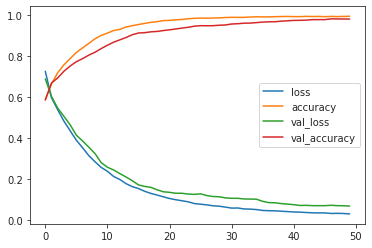

In [25]:
history[["loss", "accuracy", "val_loss", "val_accuracy"]].plot()

In [41]:
with open('./history_with_acc.csv', 'wb') as file_pi:
    pd.DataFrame(history).to_csv(file_pi)

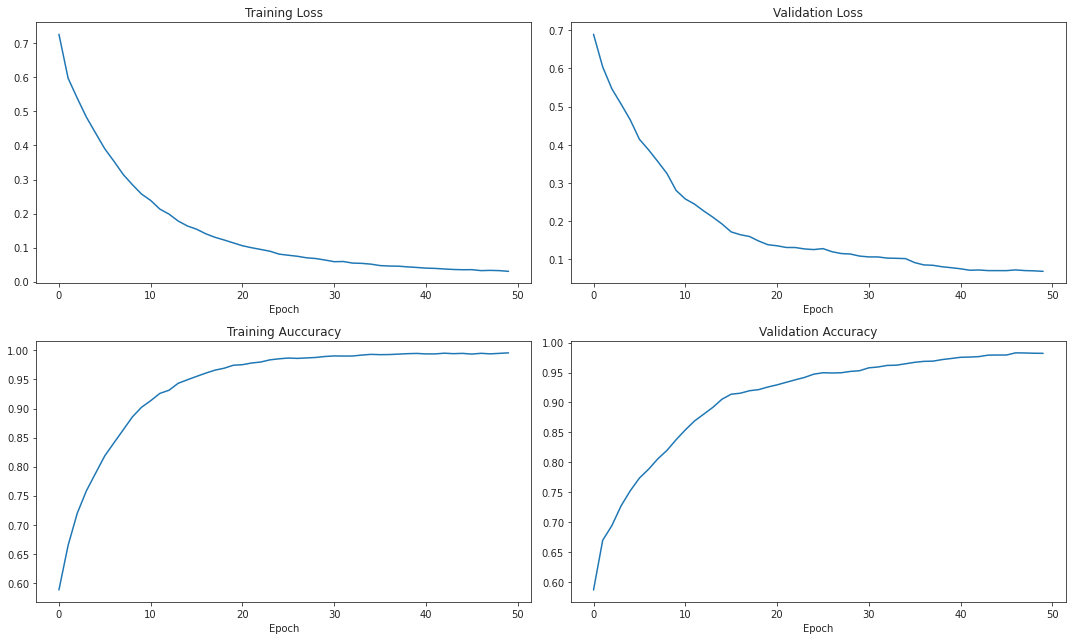

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(15, 9))
ax[0,0].title.set_text("Training Loss")
ax[0,0].plot(history['loss'])
ax[0,0].set_xlabel('Epoch')
ax[0,1].title.set_text("Validation Loss")
ax[0,1].plot(history['val_loss'])
ax[0,1].set_xlabel('Epoch')
ax[1,0].title.set_text("Training Auccuracy")
ax[1,0].plot(history['accuracy'])
ax[1,0].set_xlabel('Epoch')
ax[1,1].title.set_text("Validation Accuracy")
ax[1,1].plot(history['val_accuracy'])
ax[1,1].set_xlabel('Epoch')
plt.tight_layout()

# Prediction

In [44]:
file_path = '../input/brain-tumor-classifier/best_model.h5'

model_best = tf.keras.models.load_model(filepath=file_path)

In [46]:
y_pred = model_best.predict(X_valid)
pred = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_valid, axis=-1)

2022-02-22 03:44:57.731619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-22 03:44:58.655518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [49]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy Score: {:.3f}".format(accuracy_score(y_true, pred)))
print(classification_report(y_true, pred, target_names=['0', '1']))

Accuracy Score: 0.982
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1090
           1       0.98      0.99      0.98      1402

    accuracy                           0.98      2492
   macro avg       0.98      0.98      0.98      2492
weighted avg       0.98      0.98      0.98      2492



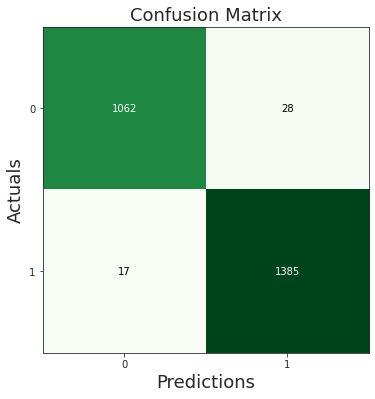

In [50]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_true, pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
fig.savefig("confusion.png")

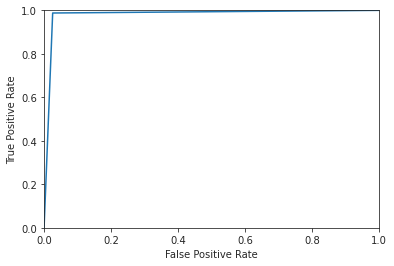

In [52]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, pred, pos_label=1)
plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

In [53]:
fpr, tpr, thresholds

(array([0.        , 0.02568807, 1.        ]),
 array([0.        , 0.98787447, 1.        ]),
 array([2, 1, 0]))

In [54]:
roc_auc_score(y_true, pred)

0.9810931958277166